The network predicts quality scores for the individual repetitions for Exercise 1 - Deep Squat. The input to the network are the raw measurement data with 117 dimensions.

In [1]:
# Import libraries and functions

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random

# The code is run on a CPU

from keras.models import Model
from keras.layers import Input, Conv1D, LSTM, Dense, Dropout, Activation, Flatten, concatenate, UpSampling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import *
from keras.layers import Lambda

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

import datetime
now = datetime.datetime.now

In [2]:
timesteps = 240  # number of timesteps
nr = 90   # number of repetitions
n_dim = 117  # dimension of the data sequences

In [3]:
import DataViconLoad   # Import the data
Correct_data, Correct_label, Incorrect_data, Incorrect_label = DataViconLoad.load_data()

# Print the size of the data 
print(Correct_data.shape, 'correct sequences')
print(Correct_label.shape, 'correct labels')
print(Incorrect_data.shape, 'incorrect sequences')
print(Incorrect_label.shape, 'incorrect labels')

(90, 240, 117) correct sequences
(90, 1) correct labels
(90, 240, 117) incorrect sequences
(90, 1) incorrect labels


In [4]:
# Split the data into training and validation sets
# Training set: 70%
# Validation set: 30%

# Sample random indices
trainidx1 = random.sample(range(0,Correct_data.shape[0]),int(nr*0.7))
trainidx2 = random.sample(range(0,Incorrect_data.shape[0]),int(nr*0.7))
valididx1 = np.setdiff1d(np.arange(0,nr,1),trainidx1)
valididx2 = np.setdiff1d(np.arange(0,nr,1),trainidx2)

# Training set: data and labels
train_x = np.concatenate((Correct_data[trainidx1,:,:],Incorrect_data[trainidx2,:,:]))
print(train_x.shape, 'training data')
train_y = np.concatenate((np.squeeze(Correct_label[trainidx1]),np.squeeze(Incorrect_label[trainidx2])))
print(train_y.shape, 'training labels')

# Validation set: data and labels
valid_x = np.concatenate((Correct_data[valididx1,:,:],Incorrect_data[valididx2,:,:]))
print(valid_x.shape, 'validation data')
valid_y = np.concatenate((np.squeeze(Correct_label[valididx1]),np.squeeze(Incorrect_label[valididx2])))
print(valid_y.shape, 'validation labels')

(124, 240, 117) training data
(124,) training labels
(56, 240, 117) validation data
(56,) validation labels


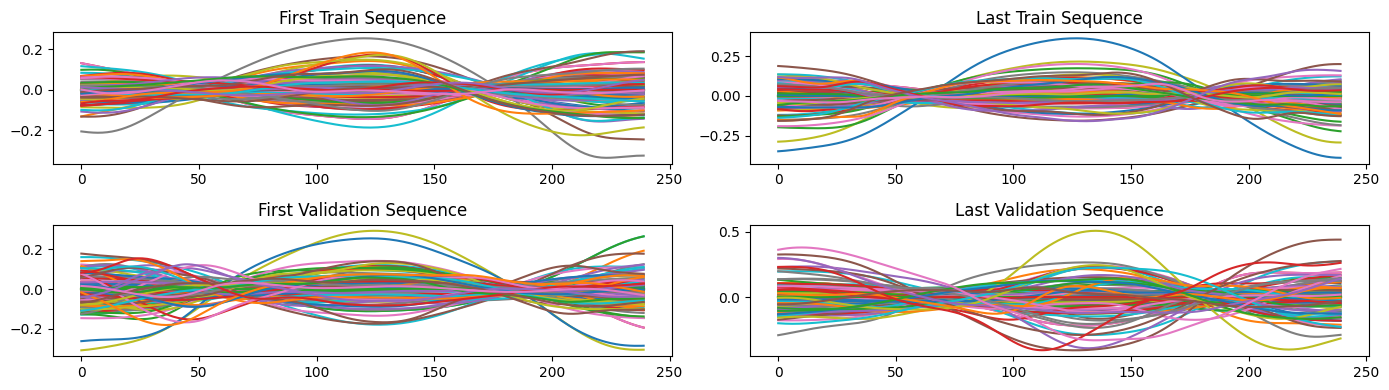

In [5]:
# Plot the first and last sequence in the training and validation sets
plt.figure(figsize = (14,4))
plt.subplot(2,2,1)
plt.plot(train_x[0])
plt.title('First Train Sequence')
plt.subplot(2,2,2)
plt.plot(train_x[-1])
plt.title('Last Train Sequence')
plt.subplot(2,2,3)
plt.plot(valid_x[0])
plt.title('First Validation Sequence')
plt.subplot(2,2,4)
plt.plot(valid_x[-1])
plt.title('Last Validation Sequence')
plt.tight_layout()
plt.show()

In [6]:
# Reduce the data length by a factor of 2, 4, and 8 
# The reduced sequences will be used as inputs to the temporal pyramid subnetwork
train_x_2 = np.zeros((train_x.shape[0], int(train_x.shape[1]/2), train_x.shape[2]))
valid_x_2 = np.zeros(train_x_2.shape)
train_x_4 = np.zeros((train_x.shape[0], int(train_x.shape[1]/4), train_x.shape[2]))
valid_x_4 = np.zeros(train_x_4.shape)
train_x_8 = np.zeros((train_x.shape[0], int(train_x.shape[1]/8), train_x.shape[2]))
valid_x_8 = np.zeros(train_x_8.shape)

train_x_2 = train_x[:,::2,:]
valid_x_2 = valid_x[:,::2,:]
train_x_4 = train_x[:,::4,:]
valid_x_4 = valid_x[:,::4,:]
train_x_8 = train_x[:,::8,:]
valid_x_8 = valid_x[:,::8,:]  

In [7]:
# Code to re-order the 117 dimensional skeleton data from the Vicon optical tracker into trunk, left arm, right arm, left leg and right leg
def reorder_data(x):
    X_trunk = np.zeros((x.shape[0],x.shape[1],12))
    X_left_arm = np.zeros((x.shape[0],x.shape[1],18))
    X_right_arm = np.zeros((x.shape[0],x.shape[1],18))
    X_left_leg = np.zeros((x.shape[0],x.shape[1],21))
    X_right_leg = np.zeros((x.shape[0],x.shape[1],21))
    X_trunk =  np.concatenate((x[:,:,15:18], x[:,:,18:21], x[:,:,24:27], x[:,:,27:30]), axis = 2)
    X_left_arm = np.concatenate((x[:,:,81:84], x[:,:,87:90], x[:,:,93:96], x[:,:,99:102], x[:,:,105:108], x[:,:,111:114]), axis = 2)
    X_right_arm = np.concatenate((x[:,:,84:87], x[:,:,90:93], x[:,:,96:99], x[:,:,102:105], x[:,:,108:111], x[:,:,114:117]), axis = 2)  
    X_left_leg = np.concatenate((x[:,:,33:36], x[:,:,39:42], x[:,:,45:48], x[:,:,51:54], x[:,:,57:60], x[:,:,63:66], x[:,:,69:72]), axis = 2)
    X_right_leg = np.concatenate((x[:,:,36:39], x[:,:,42:45], x[:,:,48:51], x[:,:,54:57], x[:,:,60:63], x[:,:,66:69], x[:,:,72:75]), axis = 2)
    x_segmented = np.concatenate((X_trunk, X_right_arm, X_left_arm, X_right_leg, X_left_leg),axis = -1)
    return x_segmented

In [8]:
# Reorder the data dimensions to correspond to the five body parts
trainx =  reorder_data(train_x)
validx =  reorder_data(valid_x)
trainx_2 =  reorder_data(train_x_2)
validx_2 =  reorder_data(valid_x_2)
trainx_4 =  reorder_data(train_x_4)
validx_4 =  reorder_data(valid_x_4)
trainx_8 =  reorder_data(train_x_8)
validx_8 =  reorder_data(valid_x_8)

In [9]:
# Define a multibranch convolutional Inception-like block
def MultiBranchConv1D(input, filters1, kernel_size1, strides1, strides2):
    print('shape of input: ', input.shape)
    x1 = Conv1D(filters=filters1, kernel_size=kernel_size1+2, strides=strides1, padding='same', activation='relu')(input)
    x1 = Dropout(0.25)(x1)
    x2 = Conv1D(filters=filters1, kernel_size=kernel_size1+6, strides=strides1, padding='same', activation='relu')(input)
    x2 = Dropout(0.25)(x2)
    x3 = Conv1D(filters=filters1, kernel_size=kernel_size1+12, strides=strides1, padding='same', activation='relu')(input)
    x3 = Dropout(0.25)(x3)
    y1 = concatenate([x1, x2, x3], axis=-1)

    x4 = Conv1D(filters=filters1, kernel_size=kernel_size1, strides=strides2, padding='same', activation='relu')(y1)
    x4 = Dropout(0.25)(x4)
    x5 = Conv1D(filters=filters1, kernel_size=kernel_size1+2, strides=strides2, padding='same', activation='relu')(y1)
    x5 = Dropout(0.25)(x5)
    x6 = Conv1D(filters=filters1, kernel_size=kernel_size1+4, strides=strides2, padding='same', activation='relu')(y1)
    x6 = Dropout(0.25)(x6)
    x = concatenate([x4, x5, x6], axis=-1)
    print('shape of x: ', x.shape)
    return x

In [10]:
# Define a temporal pyramid network
def TempPyramid(input_f, input_2, input_4, input_8, seq_len, n_dims):
    
    #### Full scale sequences
    conv1 = MultiBranchConv1D(input_f, 64, 3, 2, 2)
    
    #### Half scale sequences
    conv2 = MultiBranchConv1D(input_2, 64, 3, 2, 1)

    #### Quarter scale sequences
    conv3 = MultiBranchConv1D(input_4, 64, 3, 1, 1)

    #### Eighth scale sequences
    conv4 = MultiBranchConv1D(input_8, 64, 3, 1, 1)
    upsample1 = UpSampling1D(size = 2)(conv4)

    #### Recurrent layers
    x = concatenate([conv1, conv2, conv3, upsample1], axis=-1)
    return x    

In [11]:
n_dim = 90 # dimension after segmenting the data into body parts
n_dim1 = 12 # trunk dimension
n_dim2 = 18 # arms dimension
n_dim3 = 21 # legs dimension

# Build the model ...

#### Full scale sequences
seq_input = Input(shape = (timesteps, n_dim), name = 'full_scale')

seq_input_trunk = Lambda(lambda x: x[:, :, 0:12])(seq_input)
seq_input_left_arm = Lambda(lambda x: x[:, :, 12:30])(seq_input)
seq_input_right_arm = Lambda(lambda x: x[:, :, 30:48])(seq_input)
seq_input_left_leg = Lambda(lambda x: x[:, :, 48:69])(seq_input)
seq_input_right_leg = Lambda(lambda x: x[:, :, 69:90])(seq_input)

#### Half scale sequences
seq_input_2 = Input(shape=(int(timesteps/2), n_dim), name='half_scale')

seq_input_trunk_2 = Lambda(lambda x: x[:, :, 0:12])(seq_input_2)
seq_input_left_arm_2 = Lambda(lambda x: x[:, :, 12:30])(seq_input_2)
seq_input_right_arm_2 = Lambda(lambda x: x[:, :, 30:48])(seq_input_2)
seq_input_left_leg_2 = Lambda(lambda x: x[:, :, 48:69])(seq_input_2)
seq_input_right_leg_2 = Lambda(lambda x: x[:, :, 69:90])(seq_input_2)

#### Quarter scale sequences
seq_input_4 = Input(shape=(int(timesteps/4), n_dim), name='quarter_scale')

seq_input_trunk_4 = Lambda(lambda x: x[:, :, 0:12])(seq_input_4)
seq_input_left_arm_4 = Lambda(lambda x: x[:, :, 12:30])(seq_input_4)
seq_input_right_arm_4 = Lambda(lambda x: x[:, :, 30:48])(seq_input_4)
seq_input_left_leg_4 = Lambda(lambda x: x[:, :, 48:69])(seq_input_4)
seq_input_right_leg_4 = Lambda(lambda x: x[:, :, 69:90])(seq_input_4)

#### Eighth scale sequences
seq_input_8 = Input(shape=(int(timesteps/8), n_dim), name='eighth_scale')

seq_input_trunk_8 = Lambda(lambda x: x[:, :, 0:12])(seq_input_8)
seq_input_left_arm_8 = Lambda(lambda x: x[:, :, 12:30])(seq_input_8)
seq_input_right_arm_8 = Lambda(lambda x: x[:, :, 30:48])(seq_input_8)
seq_input_left_leg_8 = Lambda(lambda x: x[:, :, 48:69])(seq_input_8)
seq_input_right_leg_8 = Lambda(lambda x: x[:, :, 69:90])(seq_input_8)

concat_trunk = TempPyramid(seq_input_trunk, seq_input_trunk_2, seq_input_trunk_4, seq_input_trunk_8, timesteps, n_dim1)
concat_left_arm = TempPyramid(seq_input_left_arm, seq_input_left_arm_2, seq_input_left_arm_4, seq_input_left_arm_8, timesteps, n_dim2)
concat_right_arm = TempPyramid(seq_input_right_arm, seq_input_right_arm_2, seq_input_right_arm_4, seq_input_right_arm_8, timesteps, n_dim2)
concat_left_leg = TempPyramid(seq_input_left_leg, seq_input_left_leg_2, seq_input_left_leg_4, seq_input_left_leg_8, timesteps, n_dim3)
concat_right_leg = TempPyramid(seq_input_right_leg, seq_input_right_leg_2, seq_input_right_leg_4, seq_input_right_leg_8, timesteps, n_dim3)


print('concat_trunk: ', concat_trunk.shape)
print('concat_left_arm: ', concat_left_arm.shape)
print('concat_right_arm: ', concat_right_arm.shape)
print('concat_left_leg: ', concat_left_leg.shape)
print('concat_right_leg: ', concat_right_leg.shape)

concat = concatenate([concat_trunk, concat_left_arm, concat_right_arm, concat_left_leg, concat_right_leg], axis=-1)

rec = LSTM(80, return_sequences=True)(concat)
rec1 = LSTM(40, return_sequences=True)(rec)
rec1 = LSTM(40, return_sequences=True)(rec1)
rec2 = LSTM(80)(rec1)

out = Dense(1, activation = 'sigmoid')(rec2)

model = Model(inputs=[seq_input, seq_input_2, seq_input_4, seq_input_8], outputs=out)

model.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate=0.0001)) 

shape of input:  (None, 240, 12)
shape of x:  (None, 60, 192)
shape of input:  (None, 120, 12)
shape of x:  (None, 60, 192)
shape of input:  (None, 60, 12)
shape of x:  (None, 60, 192)
shape of input:  (None, 30, 12)
shape of x:  (None, 30, 192)
shape of input:  (None, 240, 18)
shape of x:  (None, 60, 192)
shape of input:  (None, 120, 18)
shape of x:  (None, 60, 192)
shape of input:  (None, 60, 18)
shape of x:  (None, 60, 192)
shape of input:  (None, 30, 18)
shape of x:  (None, 30, 192)
shape of input:  (None, 240, 18)
shape of x:  (None, 60, 192)
shape of input:  (None, 120, 18)
shape of x:  (None, 60, 192)
shape of input:  (None, 60, 18)
shape of x:  (None, 60, 192)
shape of input:  (None, 30, 18)
shape of x:  (None, 30, 192)
shape of input:  (None, 240, 21)
shape of x:  (None, 60, 192)
shape of input:  (None, 120, 21)
shape of x:  (None, 60, 192)
shape of input:  (None, 60, 21)
shape of x:  (None, 60, 192)
shape of input:  (None, 30, 21)
shape of x:  (None, 30, 192)
shape of input: 

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 eighth_scale (InputLayer)      [(None, 30, 90)]     0           []                               
                                                                                                  
 full_scale (InputLayer)        [(None, 240, 90)]    0           []                               
                                                                                                  
 half_scale (InputLayer)        [(None, 120, 90)]    0           []                               
                                                                                                  
 quarter_scale (InputLayer)     [(None, 60, 90)]     0           []                               
                                                                                              

In [13]:
t = now()
    
early_stopping = EarlyStopping(monitor='val_loss', patience = 25)

history = model.fit([trainx, trainx_2, trainx_4, trainx_8], train_y, batch_size=10, epochs=500, verbose=1, 
                validation_data=([validx, validx_2, validx_4, validx_8], valid_y), callbacks = [early_stopping])

print('Training time: %s' % (now() - t))

Epoch 1/500
13/13 [==============================] - 35s 961ms/step - loss: 0.5943 - val_loss: 0.4807
Epoch 2/500
13/13 [==============================] - 8s 619ms/step - loss: 0.4046 - val_loss: 0.3360
Epoch 3/500
13/13 [==============================] - 8s 654ms/step - loss: 0.2936 - val_loss: 0.2758
Epoch 4/500
13/13 [==============================] - 8s 626ms/step - loss: 0.2585 - val_loss: 0.2698
Epoch 5/500
13/13 [==============================] - 8s 654ms/step - loss: 0.2567 - val_loss: 0.2710
Epoch 6/500
13/13 [==============================] - 9s 670ms/step - loss: 0.2565 - val_loss: 0.2695
Epoch 7/500
13/13 [==============================] - 9s 719ms/step - loss: 0.2559 - val_loss: 0.2689
Epoch 8/500
13/13 [==============================] - 9s 684ms/step - loss: 0.2558 - val_loss: 0.2688
Epoch 9/500
13/13 [==============================] - 9s 679ms/step - loss: 0.2556 - val_loss: 0.2684
Epoch 10/500
13/13 [==============================] - 9s 703ms/step - loss: 0.2554 - val_l

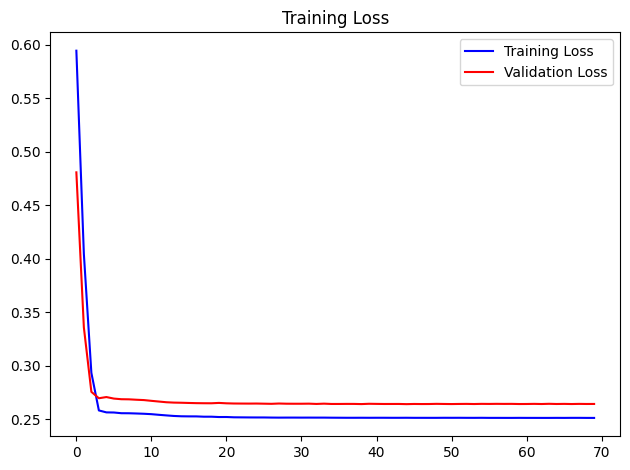

Training loss 0.251476913690567
Validation loss 0.26434454321861267


In [14]:
# Plot the results
plt.figure(1)
plt.plot(history.history['loss'], 'b', label = 'Training Loss')
plt.title('Training Loss')
plt.plot(history.history['val_loss'], 'r', label = 'Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()
# Print the minimum loss
print("Training loss", np.min(history.history['loss']))
print("Validation loss",np.min(history.history['val_loss']))    

2/2 [==============================] - 1s 227ms/step


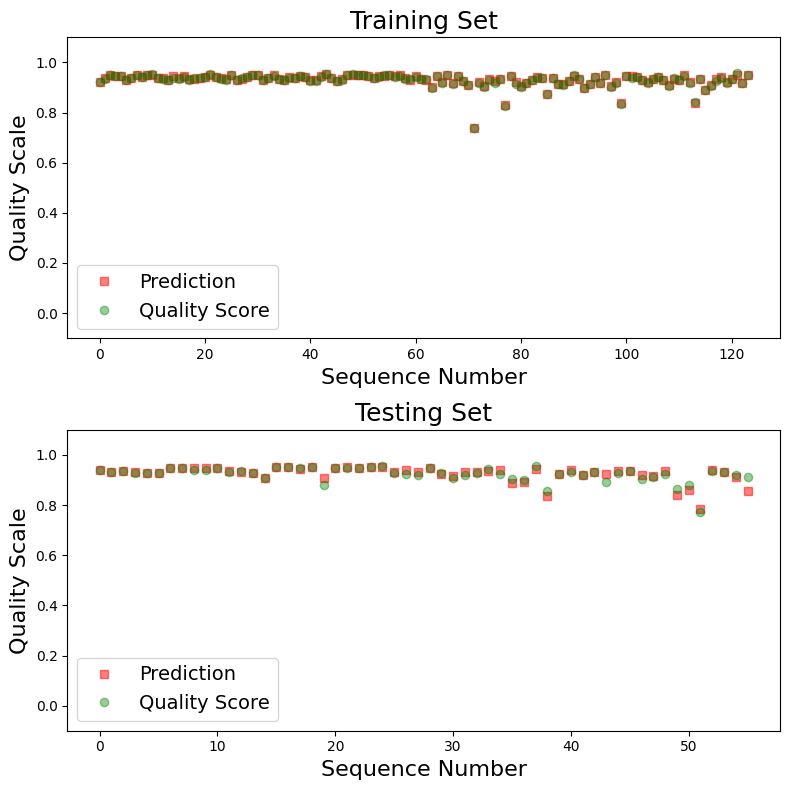

In [15]:
# Plot the prediction of the model for the training and validation sets
pred_train = model.predict([trainx, trainx_2, trainx_4, trainx_8])

pred_test = model.predict([validx, validx_2, validx_4, validx_8])

plt.figure(figsize = (8,8))
plt.subplot(2,1,1)
plt.plot(pred_train,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(train_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.ylim([-0.1,1.1])
plt.title('Training Set',fontsize=18)
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.subplot(2,1,2)
plt.plot(pred_test,'s', color='red', label='Prediction', linestyle='None', alpha = 0.5, markersize=6)
plt.plot(valid_y,'o', color='green',label='Quality Score', alpha = 0.4, markersize=6)
plt.title('Testing Set',fontsize=18)
plt.ylim([-0.1,1.1])
plt.xlabel('Sequence Number',fontsize=16)
plt.ylabel('Quality Scale',fontsize=16)
plt.legend(loc=3, prop={'size':14}) # loc:position
plt.tight_layout()
plt.savefig('SpatioTemporal.png', dpi=350)
plt.show()

In [16]:
# Calculate the cumulative deviation and rms deviation for the validation set
test_dev = abs(np.squeeze(pred_test)-valid_y)
# Cumulative deviation
mean_abs_dev = np.mean(test_dev)
# RMS deviation
rms_dev = sqrt(mean_squared_error(pred_test, valid_y))
print('Mean absolute deviation:', mean_abs_dev)
print('RMS deviation:', rms_dev)

Mean absolute deviation: 0.0074049936025483275
RMS deviation: 0.012162532204693948
